<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FinalEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image, ImageOps
import sys
import statistics


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 72 kB 853 kB/s 
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4af83e24-6643-0b08-b221-912f6dfc472b)
Mounted at /content/drive


#**Preparation for SeqNet**

In [2]:
IMG_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00085008_00_1R.jpg"
NET_NAME = ["RepVGG_A2", "RepVGG_B3"]
MODEL_NAME = ["cropped", "disc", "macula", "vascular"]
MODEL_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto/model"

"""
DATASET_NAME = 'cropped_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
NET_NAME = "RepVGG_A2" #RepVGG_A2 or RepVGG_B3
PRETRAINED = True

os.chdir(DATASET_PATH)

TRAIN_FOLDER_NAME = 'train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = 'val' #VALイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result_gray.csv' #年齢推定結果を書き出すcsv
FILENAME_RESULT_ANALYSISCSV = 'result_analysis.csv' #推定結果の解析結果を書き出すcsv
"""

'\nDATASET_NAME = \'cropped_img_trainval\'\nDATASET_PATH = \'/content/drive/MyDrive/Deep_learning/FundusPhoto\'\nNET_NAME = "RepVGG_A2" #RepVGG_A2 or RepVGG_B3\nPRETRAINED = True\n\nos.chdir(DATASET_PATH)\n\nTRAIN_FOLDER_NAME = \'train\' #TRAINイメージのフォルダ\nVAL_FOLDER_NAME = \'val\' #VALイメージのフォルダ\n\nFILENAME_LABELCSV = \'name_age.csv\' #年齢の値のcsv\nFILENAME_RESULTCSV = \'result_gray.csv\' #年齢推定結果を書き出すcsv\nFILENAME_RESULT_ANALYSISCSV = \'result_analysis.csv\' #推定結果の解析結果を書き出すcsv\n'

In [3]:
#GithubよりSeqNetをcloneする
os.chdir('/content')
!git clone https://github.com/conscienceli/SeqNet.git

#出力用フォルダを作る
output_path = "/content/SeqNet/SeqNet_output"
os.makedirs(output_path, exist_ok=True)

#作業ディレクトリをpathに移動する
os.chdir('/content/SeqNet')
#評価画像用のフォルダを作成
data_dir = "./data/test_images/"
os.makedirs(data_dir, exist_ok=True)

#Download pretrained model from Gdrive
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1OYjzu0gixtga6e7Rvb2mZoSSYJkXWRNB'

os.makedirs('./trained_model/ALL', exist_ok=True)
destination = './trained_model/ALL/Final_Emer_Iteration_3_cropsize_128_epochs_200.hdf5'
download_file_from_google_drive(file_id, destination)


#upgrade modules
!pip3 install --upgrade tensorflow==1.15.0
!pip3 install --upgrade keras==2.3.1
!pip3 install --upgrade h5py==2.10.0


"""
これを走らせる前に、predict.pyを置換する。
・artery, vein finalを削除
・出力ファイル形式を.jpgに変更
・stride_sizeを10に変更（メモリ節約のため）
"""
shutil.copy("/content/drive/MyDrive/Deep_learning/FundusPhoto/SeqNet/predict.py", "/content/SeqNet/predict.py")

Cloning into 'SeqNet'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 48 (delta 15), reused 41 (delta 10), pack-reused 0
Unpacking objects: 100% (48/48), done.
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 503 kB 57.6 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 3.8 MB 39.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=23396266db5d9f4f400be0eb4ad87951e70e780a898617a296bbe74251acdbd1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall:

'/content/SeqNet/predict.py'

In [4]:
"""
def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses
"""


##################################
#Define RepVGG-B3
##################################


def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model




class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        num_ftrs = model_ft.linear.in_features  #in_featureはA2では1408、B3では2560
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.fc = nn.Linear(in_features=num_ftrs, out_features=1)  #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x







In [5]:
def Mirror_left_eye(pil_img, img_path):
    filename = os.path.splitext(IMG_PATH)[0]
    side = filename[-1]
    if side == "R":
        flipped_img = pil_img
    elif side == "L":
        img_mirror = ImageOps.mirror(pil_img)
        flipped_img = img_mirror
    return flipped_img

def crop2square(pil_img):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = pil_img.crop(((width-height)//2, 0, (width+height)//2, height))
        return result
    else:
        result = pil_img.crop((0, (height-width)//2, width, (height+width)//2))
        return result

def crop_disc(pil_img):
    width, height = pil_img.size
    if width % 10 != 0:
        print("幅を10等分できません")
    if height % 10 != 0:
        print("高さを10等分できません")
    x_axis = int(width/10)
    y_axis = int(height/10)
    disc_img = pil_img.crop((5*x_axis, 3*y_axis, 9*x_axis, 7*y_axis))
    return disc_img

def crop_macula(pil_img):
    width, height = pil_img.size
    if width % 20 != 0:
        print("幅を5等分できません")
    if height % 20 != 0:
        print("高さを5等分できません")
    x_axis = int(width/20)
    y_axis = int(height/20)

    macula_img = pil_img.crop((4*x_axis, 7*y_axis, 10*x_axis, 13*y_axis))
    return macula_img


#評価のための画像下処理
def image_transform(pil_img):    
    #image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()])
    image_tensor = transform(pil_img)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


In [24]:
orig_img = Image.open(IMG_PATH)
cropped_img = crop2square(orig_img)
flipped_img = Mirror_left_eye(cropped_img, IMG_PATH)
disc_img = crop_disc(flipped_img)
macula_img = crop_macula(cropped_img)

###SeqNet用の下準備

SeqNet_PATH = '/content/SeqNet/'
#作業ディレクトリをpathに移動する
os.chdir(SeqNet_PATH)
#評価画像用のフォルダを作成
cropped_img.save(data_dir + "temp.jpg")
!python predict.py -i /content/SeqNet/data/test_images/ -o /content/SeqNet/SeqNet_output/
vascular_img = Image.open("/content/SeqNet/SeqNet_output/out_seg/temp.jpg")
vascular_img.convert("RGB")

IMG_NAME = [cropped_img, disc_img, macula_img, vascular_img]

Using TensorFlow backend.



2021-09-28 13:33:59.964813: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-28 13:33:59.969787: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-09-28 13:33:59.970185: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ff8eb26a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-28 13:33:59.970223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-28 13:33:59.973658: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-28 13:34:00.184394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

#**処理後の画像を並べて表示**

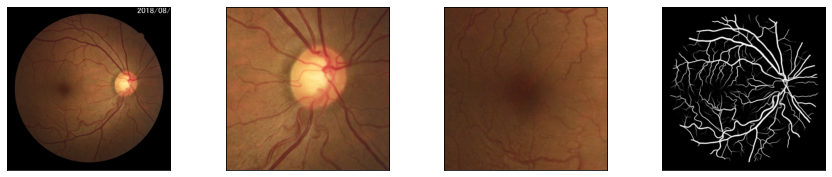

In [26]:
def show_img(im_list):
    plt.figure(figsize=(15, 3))
    for i in range(len(im_list)):
        image = im_list[i]
        #image = image.permute(1, 2, 0)
        plt.subplot(1, 4, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        #plt.gray()
        plt.imshow(image)
        

#画像の可視化
im_list = [cropped_img, disc_img, macula_img, vascular_img]
show_img(im_list)


In [29]:
####################################
#ConvNetの調整
####################################
#IMG_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_img_trainval/0/train/img00085008_00_1R.jpg"
#cropped_img = Image.open(IMG_PATH)

NET_NAME_temp = NET_NAME[0]       #["RepVGG-2B", "RepVGG3B"]
name_step = 0
MODEL_NAME_temp = MODEL_NAME[name_step] #["cropped", "disc", "macula", "vascular"]
IMG_NAME_temp = IMG_NAME[name_step]        #[cropped_img, disc_img, macula_img, vascular_img]
model_num = [0,1,2,3,4]

print(IMG_PATH)
print(NET_NAME_temp)
print(MODEL_NAME_temp)
print(model_num)


outputs = []

for i in model_num:
    if NET_NAME_temp == "RepVGG_A2":
        model_ft = create_RepVGG_A2(deploy=False)
        model_ft = mod_RepVGG()
        model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/FundusPhoto/model/'+MODEL_NAME_temp+'_A2_pretrained_'+str(i)+'.pth'))  

    elif NET_NAME_temp == "RepVGG_B3":
        model_ft = create_RepVGG_B3(deploy=False)
        model_ft = mod_RepVGG()
        model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/FundusPhoto/model/'+MODEL_NAME_temp+'_B3_pretrained_'+str(i)+'.pth')) 
    else:
        print("RepVGG_A2あるいはRepVGG_B3を指定して下さい")
        sys.exit(1)

    #GPU使用
    model_ft = model_ft.to(device)

    # prep model for evaluation
    model_ft.eval() 

    image_tensor = image_transform(IMG_NAME_temp)
    print(image_tensor.size())
    image_tensor = image_tensor.to(device)
    output = model_ft(image_tensor)

    outputs.append((output[0]*100).item())      

print(outputs)


/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00085008_00_1R.jpg
RepVGG_A2
cropped
[0, 1, 2, 3, 4]
RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block,